# Precipitation Frequency Table

__Description__: Auto-retrieve [NOAA Atlas 14](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_gis.html) precipitation statistics from [FTP](ftp://hdsc.nws.noaa.gov/pub/hdsc/data/) and calcualte the max and area-averaged precipitation frequency table for the area of interest (AOI). Also calculates the 24-hour rainfall distribution from a set of rainfall data values for 5-minute through 24-hour durations  (see NRCS Engineering Handbook Part 630 https://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=43924.wba and sample the published NOAA Atlas 14 hyetographs for the 24 hour storm event

__Input__: HUC number (can be huc8, 10 or 12)

__Output__: A spreadsheet with sheets for each duration and a sheet with the NOAA Atlas 14 volume and region numbers. For each duration, the sheet contains a table with area-averaged precipitation and confidence limits. A spreadsheet with sheets for each recurrence interval that includes the NRCS nested hyetograph for the 24 hour storm and NOAA atlas 14 hyetographs. (*Project ID + _temporal_PrecipTable.xlsx*)

- `DataRepository` folder which contains the following:
    - The *Temporal_Distributions* folder, containing [precipitation temporal distribution data](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) broken down by quartile for the specified volume, region, and duration.

    - The *Temporal_Distribution_Data_Map.json* which contains metadata used to extract the temporal distribution data from its *.csv file.

    - The *Temporal_Quartile_Ranks.xlsx* which contains the percentage of precipitation events whose temporal distributions are represented by those in each quartile. [Source](https://www.nws.noaa.gov/oh/hdsc/currentpf.html). 

---

## Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pathlib as pl
sys.path.append('..')
home = pl.Path(os.getcwd())
from src.core import *

### Parameters: 

In [3]:
## Filenames and fields:
huc = '210200010203'               # Domain huc number (e.g. 071200040505)

In [4]:
#variables
precip_table = '{0}_PrecipTable.xlsx'.format(huc)  # NOAA Data

## Paths:
datarepository_dir = home.parent/'DataRepository'
inputs_dir = home/'input'
outputs_dir = home/'output'
precip_table_dir = outputs_dir/precip_table

## Options:
display_plots = True
display_print = True
brute_force_projection = None

#### Global (project specific):

In [5]:
noaa_data_crs = 4326 #Based on newer version of GeoPandas

#atlas 14 data for sampling
atlas_14_sample_duration = 24

#nrcs data for nesting
durations = ['05m', '10m', '15m', '30m', '60m', '02h', '03h', '06h', '12h', '24h'] 
dur_names = ['5min', '10min', '15min', '30min', '60min', '2hr', '3hr', '6hr', '12hr', '24hr'] 

vol_code_filename = 'NOAA_Atlas_Volume_Codes.json'
Temporal_area_filename = 'NOAA_Temporal_Areas_US.geojson'
Temporal_Distribution_Data_Map = 'Temporal_Distribution_Data_Map.json'
Temporal_Quartile_Ranks = 'Temporal_Quartile_Ranks.xlsx'
temporal_dir = datarepository_dir/'Temporal_Distributions'

verbose = True

## Read NHD Data:

### Load as a geodataframe:

In [6]:
assert os.path.exists(str(outputs_dir/huc/'{0}_{1}.geojson'.format('huc',huc))), 'User needs to run HUC_Selection Notebook first'
hucs_gdf = gpd.read_file(outputs_dir/huc/'{0}_{1}.geojson'.format('huc',huc))

In [7]:
check_attributes(hucs_gdf)

hucs_gdf.head(1)

,objectid,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,referencegnis_ids,areaacres,areasqkm,...,name,hutype,humod,tohuc,noncontributingareaacres,noncontributingareasqkm,globalid,shape_Length,shape_Area,geometry
0,83880,{0DBB5F82-EA95-4EE3-8D88-DA4BE28373B2},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,1723704945000,None,4355.57,17.63,...,Southwestern St. John,I,NM,210200010300,0,0,{B9D6F5B7-E29C-11E2-8094-0021280458E6},36996.855567,1.966696e+07,"POLYGON ((-64.73866 18.34709, -64.73864 18.346..."


### Determine projection:
- If a projection cannot be determined automatically, search for the projection using the EPSG number on the following website: https://www.spatialreference.org/, select 'Proj4', and copy and paste the string above, setting it equal to brute_force_projection. Rerun the cell with the brute_force_projection string and the cell below.

In [8]:
print('Original Coordinate Reference System:', hucs_gdf.crs)

Original Coordinate Reference System: EPSG:4326


### Extract the area of interest, reproject, and plot:

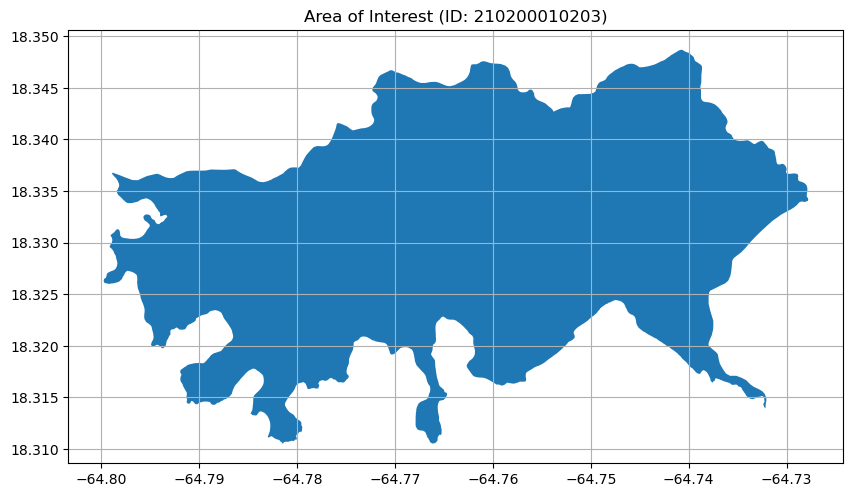

In [9]:
geo_df = hucs_gdf.to_crs(epsg = noaa_data_crs)
plot_area_of_interest(geo_df, huc)

## Identify the NOAA Atlas 14 Volume Code:

### Determine the volume and region numbers:

Volume           3
Region           1
Percent_area     100.0


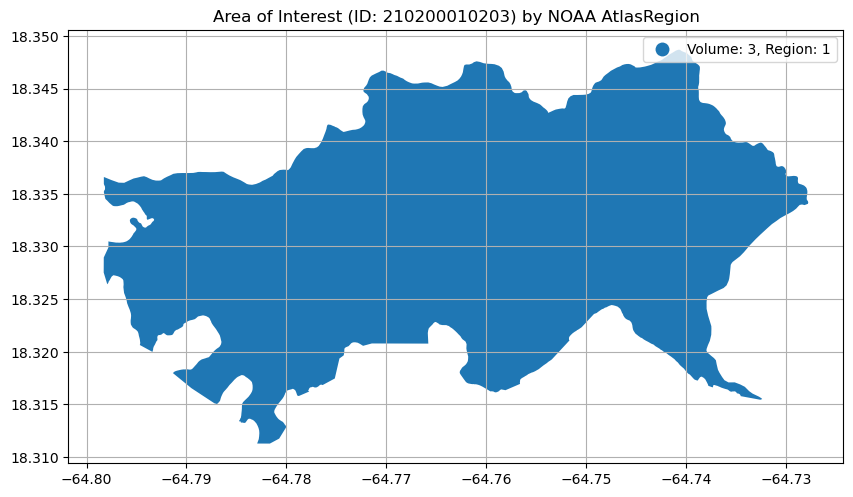

In [10]:
volume_dict, intersection_gdf = intersect_temporal_areas(geo_df, datarepository_dir, Temporal_area_filename, alldata=True)

plot_aoi_noaa_intersection(intersection_gdf, huc)

volume = volume_dict['Volume']

### Load Atlas 14 volume code from json:

In [11]:
vol_code = get_volume_code(datarepository_dir, vol_code_filename, volume)

NOAA Atlas 14 Volume Code: pr


## Retrieve the Precipitation Frequency Data:

### Get list of zip files:

In [13]:
all_zips_list, noaa_url = get_noaa_precip_values(vol_code,durations, verbose = True)

30 files found for 05m
30 files found for 10m
30 files found for 15m
30 files found for 30m
30 files found for 60m
30 files found for 02h
30 files found for 03h
30 files found for 06h
30 files found for 12h
30 files found for 24h


### Iterate through zip files and build a table:

In [20]:
df = build_precip_table(geo_df, all_zips_list, noaa_url, vol_code, 10, verbose) #The integer is the number of times to attempt getting the file from ftp

299 pr1000yr24hau.zip
299
785 Seconds


,region,TR,duration,statistic,value
0,pr,1,05m,Expected Value,0.353360
1,pr,1,05m,Lower (90%),0.301529
2,pr,1,05m,Upper (90%),0.400114
3,pr,2,05m,Expected Value,0.444751
4,pr,2,05m,Lower (90%),0.387404


None


---
## Save the Results to an Excel Workbook:

### Create an outputs directory:

In [21]:
if not os.path.isdir(outputs_dir):
    os.mkdir(outputs_dir)

### Save Precipitation Table:

In [26]:
writer = pd.ExcelWriter(outputs_dir/'{0}_PrecipTable.xlsx'.format(huc))

for i, d in enumerate(durations):
    table = pd.pivot_table(df[df['duration'] == d], values = 'value', index=['TR'], columns=['statistic'])
    table.index.name = 'Tr'
    table.columns.name = None
    table = table.sort_values(by = ['Expected Value'])
    table.to_excel(writer, sheet_name = 'AreaDepths_{}'.format(dur_names[i]))
print('0.1-percent table \n',table)

metadata = pd.DataFrame.from_dict([volume_dict])
metadata['AOI'] = str(huc)
metadata = metadata.set_index('AOI')
metadata.to_excel(writer, sheet_name = 'NOAA_Atlas_MetaData')
#print('\nNOAA_Atlas_MetaData:')
display(metadata)
    
writer.close()

0.1-percent table 
       Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1           3.172178     2.624076     3.861385
2           4.321345     3.580341     5.235437
5           6.509532     5.347205     7.848213
10          8.381515     6.832847    10.070878
25         11.166331     8.954821    13.326769
50         13.551158    10.724163    16.132252
100        16.148982    12.631960    19.201905
200        19.022710    14.693500    22.640420
500        23.227046    17.611085    27.690883
1000       26.745037    19.995888    31.951161


,Volume,Region,Percent_area
AOI,,,
210200010203,3,1,100.0


---

## Calculate NRCS nested hyetograph function 

In [31]:
import numpy as np

In [32]:
#select events to prepare nested distribution
Return_Intervals = events_initialize('NOAA')

In [38]:
dur_precip_df_noaa = c_df.loc[str(100)][['duration', 'value']].set_index('duration')

In [ ]:
def precip_hyetograph_nrcs_design(dur_precip_df_noaa:pd.DataFrame):
    ratio_to_24h = pd.DataFrame(np.arange(start=0, stop=24.1, step=0.1), columns = ['time']).set_index(['time'])
    

In [45]:
dur_precip_df_noaa['ratio'] = dur_precip_df_noaa['value']/dur_precip_df_noaa.loc['24h','value']

In [72]:
dur_precip_df_noaa

,value,ratio
duration,,
05m,0.835785,0.051755
10m,1.142210,0.070730
15m,1.466085,0.090785
30m,2.347131,0.145342
60m,3.482396,0.215642
02h,5.235305,0.324188
03h,5.841770,0.361742
06h,8.942539,0.553752
12h,12.519860,0.775272


In [119]:
cumulative_ratio = {}
cumulative_ratio['0'] = 0
cumulative_ratio['6'] = 0.5 - (dur_precip_df_noaa.loc['12h'].ratio/2)
cumulative_ratio['9'] = 0.5 - (dur_precip_df_noaa.loc['06h'].ratio/2)
cumulative_ratio['10.5'] = 0.5 - (dur_precip_df_noaa.loc['03h'].ratio/2)
cumulative_ratio['11'] = 0.5 - (dur_precip_df_noaa.loc['02h'].ratio/2)
cumulative_ratio['11.5'] = 0.5 - (dur_precip_df_noaa.loc['60m'].ratio/2)
cumulative_ratio['11.75'] = 0.5 - (dur_precip_df_noaa.loc['30m'].ratio/2)
cumulative_ratio['11.875'] = 0.5 - (dur_precip_df_noaa.loc['15m'].ratio/2)
cumulative_ratio['11.9167'] = 0.5 - (dur_precip_df_noaa.loc['10m'].ratio/2)


In [120]:
ratio_to_24h = pd.DataFrame(np.arange(start=0, stop=241, step=1), columns = ['time']).set_index(['time'])

In [242]:
def nrcs_nesting_eqn(t:int,cumulative_ratio:pd.DataFrame,dur_precip_df_noaa:pd.DataFrame):
    '''
    From NRCS-Part-630-NEH-Chapter-4-rainfall.pdf
    The design rainfall 
    distribution is developed to have the 100-year 24-hour rainfall, the 100-year 12-hour rainfall, 
    etc., down to the 100-year 5-minute rainfall imbedded in a single storm
    '''
    # Step 3 
    #multiplied 100th to t threshold to account for floats
    if t <= 90:
        #eqn 4-1
        a = (2/3*cumulative_ratio['9'] - cumulative_ratio['6'])/18
        b = (cumulative_ratio['6'] - 36*a)/6
        crr = a*((t/10)**2) + b*(t/10)
        
    elif t<=105:
        #eqn 4-2
        a2 =  (9/10.5 * cumulative_ratio['10.5'] - cumulative_ratio['9']) / 13.5
        b2 = (cumulative_ratio['9'] -81*a2) / 9
        crr = a2*((t/10)**2)+b2*(t/10)

    elif t<= 115:
        #eqn 4-3
        a3 = 2 * (cumulative_ratio['11.5'] - 2*cumulative_ratio['11'] + cumulative_ratio['10.5'])
        b3 = cumulative_ratio['11.5'] - cumulative_ratio['10.5'] - 22*a3
        c3 = cumulative_ratio['11'] - 121*a3 - 11*b3
        crr = a3 * ((t/10)**2) +b3*(t/10)+c3

    elif t<= 117:
        #test with 11.6
        intensity_115 = (cumulative_ratio['11.5'] - cumulative_ratio[114])/0.1
        if t <= 116:
            factor_t = -0.867*intensity_115 +0.4337       
        elif t <= 117:
            factor_t = -0.4917*(intensity_115) +0.8182
            if factor_t > 0.799:
                factor_t = 0.799
        crr = cumulative_ratio['11.5']  + factor_t*(cumulative_ratio['11.75']-cumulative_ratio['11.5'])
    elif t<= 118:
        #CRR(11.8)=CRR(11.75)+(11.8–11.75)/(11.875–11.75)(CRR(11.875)–CRR(11.75))
        crr = cumulative_ratio['11.75']+ 0.4*(cumulative_ratio['11.875']-cumulative_ratio['11.75'])
    elif t<= 119:
        #CRR(11.9)=CRR(11.875)+(11.9–11.875)/(11.9167–11.875)(CRR(11.9167)–CRR(11.875))
        crr = cumulative_ratio['11.875']+0.6*(cumulative_ratio['11.9167']-cumulative_ratio['11.875'])                                     
    elif t <= 120:
        #6-min / 24-hr ratio = 5-min / 24-hr ratio + 0.2 (10-min /24-hr ratio – 5-min /24-hr ratio)
        #Ratio(12.0) = Ratio(12.1) - 6-minute/24-hour ratio
        six_min_ratio = dur_precip_df_noaa.loc['05m'].ratio +0.2*(dur_precip_df_noaa.loc['10m'].ratio-dur_precip_df_noaa.loc['05m'].ratio)
        t_ahead = 121
        crr_ahead = 1 - cumulative_ratio[(240 - t_ahead)]
        crr = crr_ahead - six_min_ratio
    else:
        assert t>120, 'something is wrong with the if elif statements above'
        crr = 1 - cumulative_ratio[(240 - t)]
    #save to dictionary for second half look up
    cumulative_ratio[t] = crr

    return crr

In [243]:
ratio_to_24h['precip'] = 0.0
ratio_to_24h['cu_precip_ratio'] = ratio_to_24h.apply(lambda x: nrcs_nesting_eqn(x.name,cumulative_ratio,dur_precip_df_noaa), axis=1)
ratio_to_24h['incremental_precip_ratio'] = ratio_to_24h['cu_precip_ratio'].diff()

In [244]:
ratio_to_24h.loc[ratio_to_24h['cu_precip_ratio'] >1]

,precip,cu_precip_ratio,incremental_precip_ratio
time,,,


<Axes: xlabel='time'>

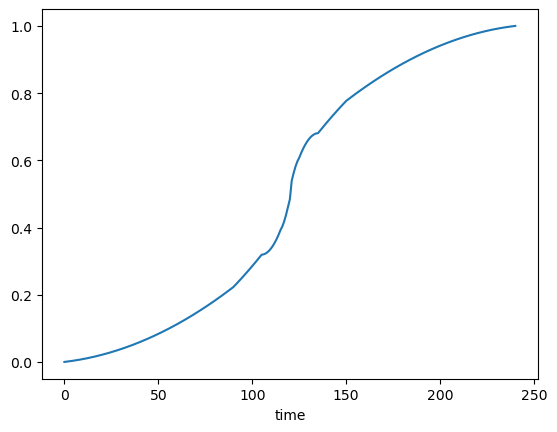

In [245]:
ratio_to_24h['cu_precip_ratio'].plot()

In [ ]:
precip_hyetograph_nrcs(precip_df)   

In [ ]:
c_df = df[df['statistic'] =='Expected Value'].set_index('TR')
hyetos = {}
for evnt in Return_Intervals:
    precip_df = c_df.loc[str(evnt)][['duration', 'value']].set_index('duration')
    hyetos[str(evnt)] = precip_hyetograph_nrcs(dur_precip_df_noaa)   

#### Plot to check behavior of 100 year recurrence interval

In [20]:
h100 = hyetos['100'].rename(columns = {'ratio':'Cumulative Distribution','t_step':'Time','slope':'100 year Distribution'}, inplace = False)

<AxesSubplot:xlabel='Time (hours)', ylabel='Precipitation (inches)'>

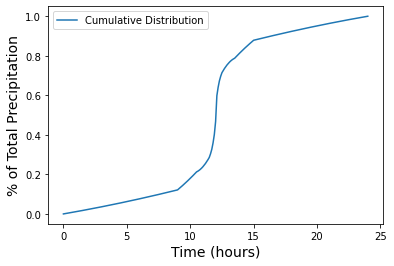

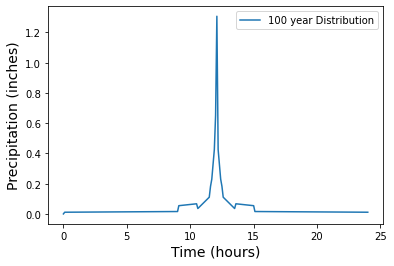

In [21]:
p1 = h100.plot('Time','Cumulative Distribution')
p1.legend()
p1.set_xlabel('Time (hours)', fontsize=14)
p1.set_ylabel('% of Total Precipitation', fontsize=14)

p2 = h100.plot('Time', '100 year Distribution')
p2.legend()
p2.set_xlabel('Time (hours)', fontsize=14)
p2.set_ylabel('Precipitation (inches)', fontsize=14)

p1
p2

### Save Nested Hyetograph:

In [22]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_nrcs_PrecipTable.xlsx'.format(Project_Area, select_data))

for i, d in enumerate(c_df.index.astype(str).tolist()[1:10]):
    table = hyetos[d][['ratio', 'slope']]
    hyetos[d].to_excel(writer, sheet_name = f'nrcs_hye_{d}')
    #print(table)
writer.save()

---

## Apply NOAA Atlas 14 hyetograph distributions 

#### NOAA Atlas 14 Volume and Region:

In [23]:
if 'Volume' not in locals(): 
    volume, region = get_volume_region(precip_table_dir, display_print = display_print)

NOAA Atlas 14: Volume 2, Region 1


#### Temporal distribution data map:

In [24]:
datarepository_dir

WindowsPath('C:/Users/cusmith/OneDrive - Stantec Office 365/git/Hydromet/DataRepository')

In [25]:
qmap = get_temporal_map(datarepository_dir, Temporal_Distribution_Data_Map, volume, region, atlas_14_sample_duration, display_print)

{'map': {'q1': [0, 9], 'q2': [11, 20], 'q3': [22, 31], 'q4': [33, 42]}, 'skiprows': 12}


#### Precipitation temporal distribution:

In [26]:
raw_temporals = get_temporals(temporal_dir, volume, region, atlas_14_sample_duration, qmap, display_print)

,0.0,8.3,16.7,25.0,33.3,41.7,50.0,58.3,66.7,75.0,83.3,91.7,100.0
percent of duration,,,,,,,,,,,,,
10%,0,55.1,85.7,96.2,99.1,99.9,100.0,100.0,100.0,100.0,100.0,100.0,100.0
20%,0,41.8,71.0,86.7,94.4,97.9,99.3,99.8,100.0,100.0,100.0,100.0,100.0


None


#### Temporal quartile ranks:

In [27]:
qrank = get_quartile_rank(datarepository_dir, Temporal_Quartile_Ranks, volume, region, atlas_14_sample_duration, display_print)

[0.36, 0.26, 0.23, 0.15]


---

## Show Temporal Distributions:

### Reformat and plot the temporal distribution data:

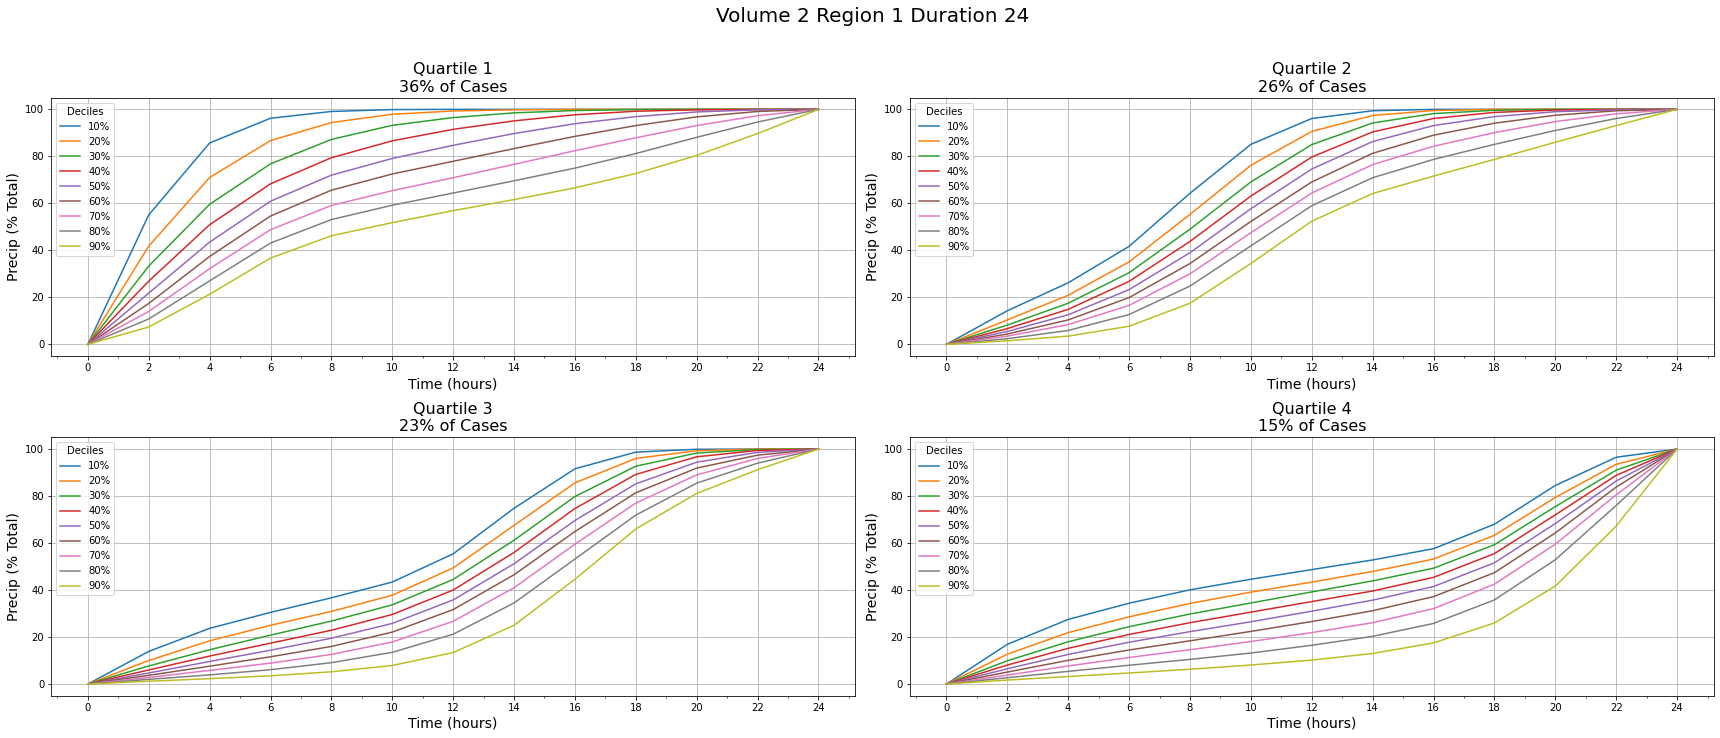

In [28]:
curve_group = get_quartiles(raw_temporals, atlas_14_sample_duration, qrank, qmap, volume, region, plot = display_plots)

## Select Temporal Distributions:

#### Combine deciles and quartiles into 1 dataframe

In [29]:
all_distro = pd.concat([curve_group['q1'], curve_group['q2'], curve_group['q3'], curve_group['q4']], axis=1, keys=['q1','q2','q3','q4'])
all_distro.head(2)

q1                                                   q2  ...   q3  \
        10%   20%   30%   40%   50%   60%   70%   80%  90%   10%  ...  90%   
hours                                                             ...        
0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0  ...  0.0   
2.0    55.1  41.8  33.3  26.9  21.8  17.4  14.0  10.8  7.4  14.3  ...  1.2   

         q4                                           
        10%   20%  30%  40%  50%  60%  70%  80%  90%  
hours                                                 
0.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2.0    16.9  12.7  9.9  8.1  6.5  5.1  3.8  2.7  1.7  

[2 rows x 36 columns]

#### Set Conservative Sampling Plan

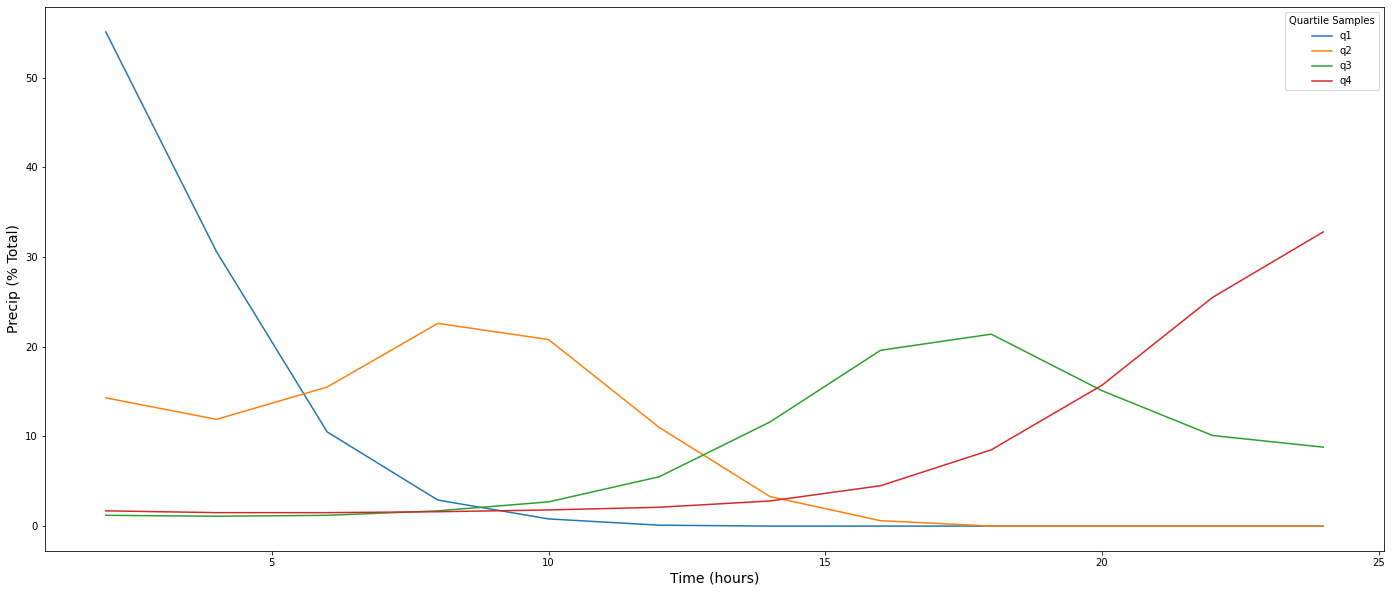

In [30]:
## User selected limiting sample from each quartile:
samples = ['10%', '10%', '90%', '90%']

## Plot selected samples:
select_distro = pd.concat([all_distro['q1'][samples[0]], all_distro['q2'][samples[1]], all_distro['q3'][samples[2]], all_distro['q4'][samples[3]]], axis=1, keys=['q1','q2','q3','q4'])
select_distro_hyetograph = pd.concat([all_distro.diff()['q1'][samples[0]], all_distro.diff()['q2'][samples[1]], all_distro.diff()['q3'][samples[2]], all_distro.diff()['q4'][samples[3]]], axis=1,keys=['q1', 'q2', 'q3', 'q4'])
ax = select_distro_hyetograph.plot(figsize=(24, 10))
ax.legend(title = 'Quartile Samples')
ax.set_xlabel('Time (hours)', fontsize=14)
ax.set_ylabel('Precip (% Total)', fontsize=14)
ax.plot();

#### Check sample weights

In [31]:
## Weighted probability of each sample:
weights_df = pd.DataFrame(data = qrank, columns = ['weight'])
weights_df.index = ['q1', 'q2', 'q3', 'q4']
weights_df

,weight
q1,0.36
q2,0.26
q3,0.23
q4,0.15


---

## Save the Results:

In [32]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_atlas_temporal_PrecipTable.xlsx'.format(Project_Area, select_data))

for i, d in enumerate(select_distro.columns):
    table = select_distro[d]/100.0
    table.to_excel(writer, sheet_name = f'atlas_hye_{d}')
weights_df.to_excel(writer, sheet_name = 'atlas_hye_weights')
 
writer.save()

## END